In [1]:
import sys
sys.path.append('../experiments/regression/')

from copy import deepcopy

import math
import numpy as np
import torch
import pandas as pd
import gpytorch

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2.5)

from gpytorch import mlls
from online_gp import models
from online_gp.models.stems import Identity
from online_gp.utils.cuda import try_cuda


sns.set_style('white')
torch.__version__

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


'1.7.0'

In [2]:
def random_split(*tensors, sizes):
    num_rows = tensors[0].size(0)
    assert len(sizes) == 2
    assert sum(sizes) == num_rows
    
    a_idxs = torch.randint(0, num_rows, (sizes[0],))
    a_mask = torch.zeros(num_rows).bool()
    a_mask[a_idxs] += 1
    b_idxs = torch.masked_select(torch.arange(0, num_rows), ~a_mask)
    
    split_tensors = [(tensor[a_idxs], tensor[b_idxs]) for tensor in tensors]
    return split_tensors

In [3]:
def get_data(num_rows, shuffle=False, fn='fx'):
    if fn == 'fx':
        fx_rawdata = pd.read_csv(
            'https://raw.githubusercontent.com/trungngv/cogp/master/data/fx/fx2007-processed.csv',
            header=None
        )
        X = torch.arange(0, fx_rawdata[3].shape[0]).view(-1,1).float()
        Y = torch.from_numpy(fx_rawdata[3].values).float()
    elif fn == 'sine':
        X = torch.linspace(-1, 1, num_rows)
        Y = torch.sin(4 * X) + 4e-1 * torch.randn(*X.shape)
    elif fn == 'cos':
        X = torch.linspace(-1, 1, num_rows)
        Y = torch.cos(4 * X) + 4e-1 * torch.randn(*X.shape)
    
    X, Y = try_cuda(X, Y)
    X, Y = X.view(-1, 1), Y.view(-1, 1)
    X, Y = X[:num_rows], Y[:num_rows]
    
    if shuffle:
        row_perm = torch.randperm(X.size(0))
        X = X[row_perm]
        Y = Y[row_perm]
    
    return X, Y

def preprocess_data(X, Y, num_init):
    dataset_size = X.size(0)
    
    x_min, _ = X.min(0)
    x_max, _ = X.max(0)
    x_range = x_max - x_min
    X = 2 * ((X - x_min) / x_range - 0.5)

    tmean = Y.mean()
    tstd = Y.std()
    Y = (Y - tmean) / tstd

    init_x, X = X[:num_init], X[num_init:]
    init_y, Y = Y[:num_init], Y[num_init:]
    
    return init_x, init_y, X, Y

In [4]:
def draw_plot(model, train_x, train_y, test_x, test_y, inducing_x, inducing_f, ax, color, show_legend=False):
    inducing_x = inducing_x.detach().cpu()
    inducing_f = inducing_f.detach().cpu()
    train_x, train_y = train_x.cpu().squeeze(-1), train_y.cpu().squeeze(-1)
    test_x, test_y = test_x.cpu().squeeze(-1), test_y.cpu().squeeze(-1)
    
    x_min = min(train_x.min(), test_x.min(), inducing_x.min())
    x_max = max(train_x.max(), test_x.max(), inducing_x.max())
    xlim = (x_min - 1e-1, x_max + 1e-1)
    x_grid = try_cuda(torch.linspace(*xlim, 200))

    model.eval()
    with torch.no_grad():
        mean, var = model.predict(x_grid)
#         pred_dist = model(x_grid)
#         mean, var = pred_dist.mean, pred_dist.variance
        lb, ub = mean - 2 * var.sqrt(), mean + 2 * var.sqrt()

    mean = mean.cpu().view(-1)
    lb, ub = lb.cpu().view(-1), ub.cpu().view(-1)
    
    ax.plot(x_grid.cpu(), mean, linewidth=1, color=color)
    ax.fill_between(x_grid.cpu(), lb, ub, alpha = 0.22, color=color)
    
    ax.scatter(train_x.cpu(), train_y.cpu(), color="black", s=32, edgecolors='none', label='observed')
    if test_x is not None:
        ax.scatter(test_x.cpu(), test_y.cpu(), color="black", s=32, facecolors='none', label='unobserved')
        
    ax.scatter(inducing_x, inducing_f, color = "red", marker="+", linewidth=3, s=128, label='inducing')
    
    ax.set_xlim((-1.1, 1.1))
    ax.set_xlabel('x')
    ax.set_ylim((-3, 3))
    sns.despine()
    if show_legend:
        ax.legend(ncol=3, bbox_to_anchor=(0., 1.2))
    plt.tight_layout()
    return ax

## Plot Options

In [5]:
palette = sns.color_palette('bright')
model_colors = dict(exact_gp_regression=palette[7], wiski_gp_regression=palette[4], svgp_regression=palette[0],
                   sgpr=palette[9])
chunk_size = 10

### O-SGPR, IID data

In [6]:
inducing_point_init = (-1, 1)
X, Y = get_data(num_rows=4 * chunk_size - 1, shuffle=True)
init_x, init_y, X, Y = preprocess_data(X, Y, num_init=chunk_size)

covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=3)

inducing_points = torch.linspace(*inducing_point_init, 12)
osgpr_model = models.StreamingSGPR(inducing_points, learn_inducing_locations=True, 
                                   covar_module=covar_module, num_data=init_x.size(0), jitter=1e-3)
osgpr_model = try_cuda(osgpr_model)

In [7]:
elbo = mlls.VariationalELBO(osgpr_model.likelihood, osgpr_model, num_data=init_x.size(0))
mll = mlls.ExactMarginalLogLikelihood(osgpr_model.likelihood, osgpr_model)
trainable_params = [
    dict(params=osgpr_model.likelihood.parameters(), lr=1e-1),
    dict(params=osgpr_model.covar_module.parameters(), lr=1e-1),
    dict(params=osgpr_model.variational_strategy.inducing_points, lr=1e-2),
    dict(params=osgpr_model.variational_strategy._variational_distribution.parameters(), lr=1e-2)
]
optimizer = torch.optim.Adam(trainable_params)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 400, 1e-4)

osgpr_model.train()
records = []
for i in range(400):
    optimizer.zero_grad()
    train_dist = osgpr_model(init_x)
    loss = -elbo(train_dist, init_y.squeeze(-1)).sum()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

osgpr_model.eval()
osgpr_model = try_cuda(osgpr_model.get_fantasy_model(init_x, init_y, resample_ratio=0))

/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


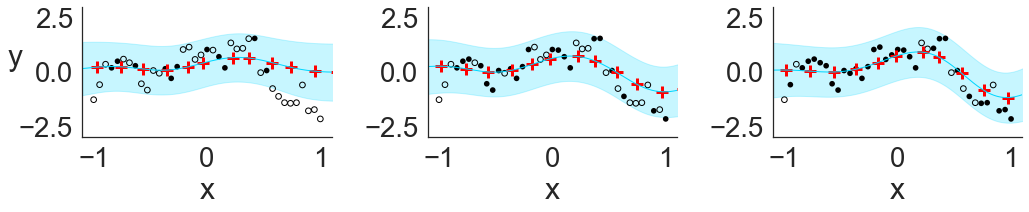

In [8]:
fig = plt.figure(figsize=(15, 4))
subplot_count = 1

for t, (x, y) in enumerate(zip(X, Y)):
    if t % chunk_size == 0:
        inducing_x = osgpr_model.variational_strategy.inducing_points
        inducing_f = osgpr_model.variational_strategy.variational_distribution.loc
        train_x = torch.cat([init_x, X[:t+1]])
        train_y = torch.cat([init_y, Y[:t+1]])
        ax = fig.add_subplot(1, 3, subplot_count)
        if subplot_count == 1:
            ax.set_ylabel('y', rotation=0)
        subplot_count += 1

        ax = draw_plot(osgpr_model, train_x, train_y, X[t+1:], Y[t+1:], inducing_x, inducing_f, ax,
                       model_colors['sgpr'])
    
    elbo = models.StreamingSGPRBound(osgpr_model)
    trainable_params = [
        dict(params=osgpr_model.likelihood.parameters(), lr=1e-2),
        dict(params=osgpr_model.covar_module.parameters(), lr=1e-2),
        dict(params=osgpr_model.variational_strategy.inducing_points, lr=1e-3),
    ]
    optimizer = torch.optim.Adam(trainable_params)
    for _ in range(1):
        optimizer.zero_grad()
        loss = -elbo(x.view(-1, 1), y.view(-1, 1))
        loss.backward()
        optimizer.step()
        
    resample_ratio = 0  # no need to resample if data are IID
    osgpr_model = try_cuda(osgpr_model.get_fantasy_model(x.view(-1, 1), y.view(-1, 1), resample_ratio))
    
# fig.suptitle("O-SGPR, IID observations")
plt.subplots_adjust(top=0.80)
plt.savefig('./sgpr_stock_price_iid.pdf')

### O-SGPR, time-series data

In [9]:
inducing_point_init = (-1, 1)
X, Y = get_data(num_rows=4 * chunk_size - 1, shuffle=False)
init_x, init_y, X, Y = preprocess_data(X, Y, num_init=chunk_size)

covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=3)

inducing_points = torch.linspace(*inducing_point_init, 12)
osgpr_model = models.StreamingSGPR(inducing_points, learn_inducing_locations=True, 
                                   covar_module=covar_module, num_data=init_x.size(0), jitter=1e-3)
osgpr_model = try_cuda(osgpr_model)

In [10]:
elbo = mlls.VariationalELBO(osgpr_model.likelihood, osgpr_model, num_data=init_x.size(0))
mll = mlls.ExactMarginalLogLikelihood(osgpr_model.likelihood, osgpr_model)
trainable_params = [
    dict(params=osgpr_model.likelihood.parameters(), lr=1e-1),
    dict(params=osgpr_model.covar_module.parameters(), lr=1e-1),
    dict(params=osgpr_model.variational_strategy.inducing_points, lr=1e-2),
    dict(params=osgpr_model.variational_strategy._variational_distribution.parameters(), lr=1e-2)
]
optimizer = torch.optim.Adam(trainable_params)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 400, 1e-4)

osgpr_model.train()
records = []
for i in range(400):
    optimizer.zero_grad()
    train_dist = osgpr_model(init_x)
    loss = -elbo(train_dist, init_y.squeeze(-1)).sum()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

osgpr_model.eval()
osgpr_model = try_cuda(osgpr_model.get_fantasy_model(init_x, init_y, resample_ratio=0))

/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


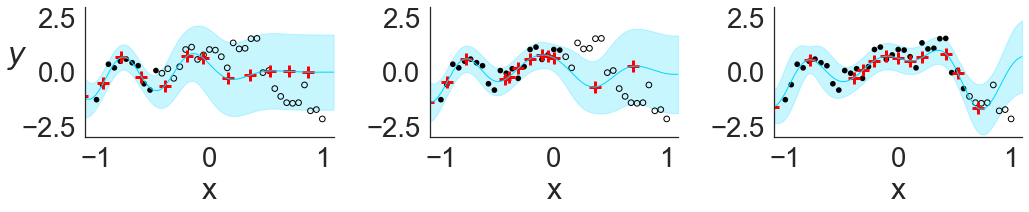

In [11]:
fig = plt.figure(figsize=(15, 4))
subplot_count = 1
# osgpr_model.set_lr(online_lr)
for t, (x, y) in enumerate(zip(X, Y)):
    if t % chunk_size == 0:
        inducing_x = osgpr_model.variational_strategy.inducing_points
        inducing_f = osgpr_model.variational_strategy.variational_distribution.loc
        train_x = torch.cat([init_x, X[:t+1]])
        train_y = torch.cat([init_y, Y[:t+1]])
        ax = fig.add_subplot(1, 3, subplot_count)
        if subplot_count == 1:
            ax.set_ylabel('$y$', rotation=0)
        subplot_count += 1

        ax = draw_plot(osgpr_model, train_x, train_y, X[t+1:], Y[t+1:], inducing_x, inducing_f, ax,
                       model_colors['sgpr'])
    
    elbo = models.StreamingSGPRBound(osgpr_model)
    trainable_params = [
        dict(params=osgpr_model.likelihood.parameters(), lr=1e-2),
        dict(params=osgpr_model.covar_module.parameters(), lr=1e-2),
        dict(params=osgpr_model.variational_strategy.inducing_points, lr=1e-3),
    ]
    optimizer = torch.optim.Adam(trainable_params)
    for _ in range(1):
        optimizer.zero_grad()
        loss = -elbo(x.view(-1, 1), y.view(-1, 1))
        loss.backward()
        optimizer.step()
        
    resample_ratio = 0.1 if t % 2 == 1 else 0
    osgpr_model = try_cuda(osgpr_model.get_fantasy_model(x.view(-1, 1), y.view(-1, 1), resample_ratio))
    
# fig.suptitle("O-SGPR, non-IID observations")
plt.subplots_adjust(top=0.80)
plt.savefig('./sgpr_stock_price_non_iid.pdf')

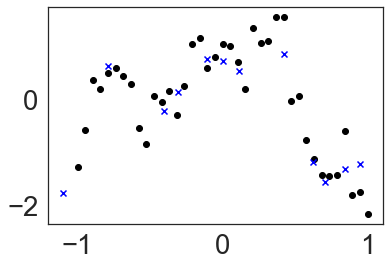

In [12]:
plt.scatter(init_x.cpu(), init_y.cpu(), color='black')
plt.scatter(X.cpu(), Y.cpu(), color='black')
plt.scatter(
    osgpr_model.variational_strategy.inducing_points.detach().cpu(),
    osgpr_model.pseudotargets.detach().cpu(),
    color='blue', marker='x'
)
# plt.scatter(
#     osgpr_model.variational_strategy.inducing_points.detach().cpu(),
#     osgpr_model.variational_strategy.variational_distribution.mean.detach().cpu(),
#     color='red'
# )

## O-SVGP Hyperparameters

In [13]:
osvgp_kwargs = dict(
    num_inducing=12,
    lr=1e-1,
    streaming=True,
    prior_beta=1e-3,
    online_beta=1e-3,
    num_update_steps=8,
)

online_lr = 1e-2
inducing_point_init = (-1, 1)
num_fit_epochs = 400

### O-SVGP w/ IID data

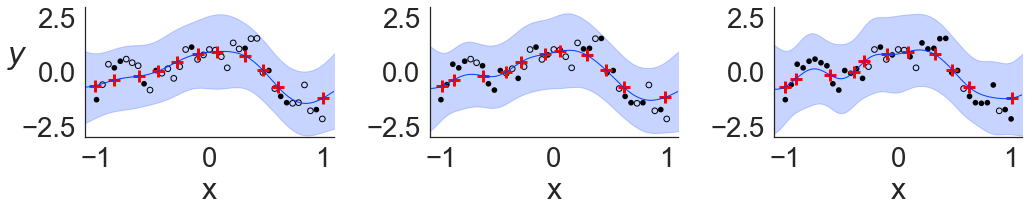

In [14]:
X, Y = get_data(num_rows=4 * chunk_size - 1, shuffle=True)
init_x, init_y, X, Y = preprocess_data(X, Y, num_init=chunk_size)

stem = Identity(input_dim=X.size(-1))
covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=3)

inducing_points = torch.linspace(*inducing_point_init, osvgp_kwargs['num_inducing'])
osvgp_model = models.OnlineSVGPRegression(stem, init_x, init_y, learn_inducing_locations=True, 
                                   covar_module=covar_module, inducing_points=inducing_points,
                                   **osvgp_kwargs)
osvgp_model = try_cuda(osvgp_model)

pretrain_metrics = osvgp_model.fit(init_x, init_y, num_fit_epochs)  # pretrain model

fig = plt.figure(figsize=(15, 4))
subplot_count = 1
osvgp_model.set_lr(online_lr)
for t, (x, y) in enumerate(zip(X, Y)):
    if t % chunk_size == 0:
        inducing_x = osvgp_model.gp.variational_strategy.inducing_points
        inducing_f = osvgp_model.gp.variational_strategy.variational_distribution.loc
        train_x = torch.cat([init_x, X[:t+1]])
        train_y = torch.cat([init_y, Y[:t+1]])
        ax = fig.add_subplot(1, 3, subplot_count)
        if subplot_count == 1:
            ax.set_ylabel('$y$', rotation=0)
        subplot_count += 1

        ax = draw_plot(osvgp_model, train_x, train_y, X[t+1:], Y[t+1:], inducing_x, inducing_f, ax,
                       model_colors['svgp_regression'])
    
    osvgp_model.update(x, y)

# fig.suptitle("O-SVGP, IID observations")
plt.subplots_adjust(top=0.80)
# plt.savefig('figures/regression/stock_price_legend.pdf')
plt.savefig('./svgp_stock_price_iid.pdf')

### O-SVGP, time-series data

/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


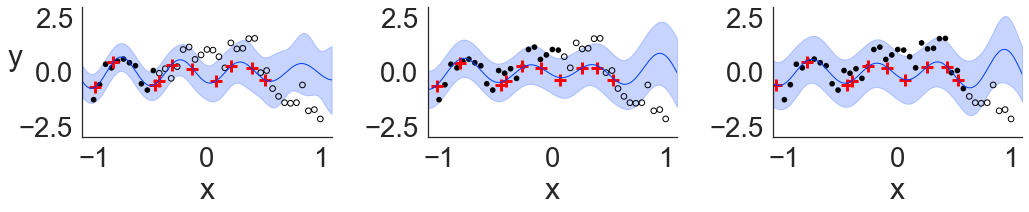

In [15]:
X, Y = get_data(num_rows=4 * chunk_size - 1, shuffle=False)
init_x, init_y, X, Y = preprocess_data(X, Y, num_init=chunk_size)

stem = Identity(input_dim=X.size(-1))
covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=3)

inducing_points = torch.linspace(*inducing_point_init, 10)
osvgp_model = models.OnlineSVGPRegression(stem, init_x, init_y, learn_inducing_locations=True, 
                                   covar_module=covar_module, inducing_points=inducing_points,
                                   **osvgp_kwargs)
osvgp_model = try_cuda(osvgp_model)
osvgp_model.fit(init_x, init_y, num_fit_epochs)

fig = plt.figure(figsize=(15, 4))
subplot_count = 1
osvgp_model.set_lr(online_lr)
for t, (x, y) in enumerate(zip(X, Y)):
    osvgp_model.update(x, y)
    if t % chunk_size == 0:
        inducing_x = osvgp_model.gp.variational_strategy.inducing_points
        inducing_f = osvgp_model.gp.variational_strategy.variational_distribution.loc
        train_x = torch.cat([init_x, X[:t+1]])
        train_y = torch.cat([init_y, Y[:t+1]])
        ax = fig.add_subplot(1, 3, subplot_count)
        if subplot_count == 1:
            ax.set_ylabel('y', rotation=0)
        subplot_count += 1

        ax = draw_plot(osvgp_model, train_x, train_y, X[t+1:], Y[t+1:], inducing_x, inducing_f, ax,
                       model_colors['svgp_regression'])

# fig.suptitle("O-SVGP, non-IID observations")
plt.subplots_adjust(top=0.80)
plt.savefig('./svgp_stock_price_non_iid.pdf')

### WISKI w/ IID data

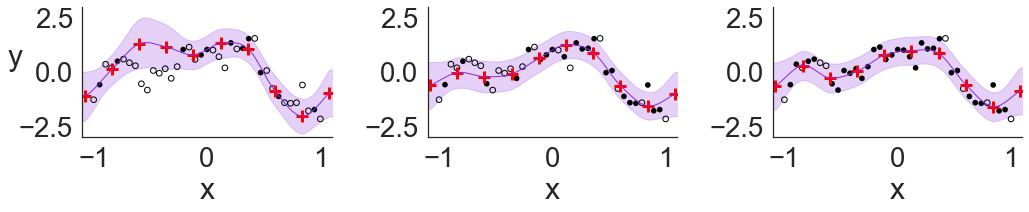

In [18]:
X, Y = get_data(num_rows=chunk_size * 4 - 1, shuffle=True)
init_x, init_y, X, Y = preprocess_data(X, Y, num_init=chunk_size)
stem = Identity(input_dim=1)
covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=3)

wiski_model = models.OnlineSKIRegression(stem, init_x, init_y, lr=1e-1, grid_size=12, grid_bound=1, covar_module=covar_module)
wiski_model = try_cuda(wiski_model)
wiski_model.fit(init_x, init_y, 200)  # pretrain model

fig = plt.figure(figsize=(15, 4))
subplot_count = 1
wiski_model.set_lr(1e-2)
for t, (x, y) in enumerate(zip(X, Y)):
    wiski_model.update(x, y)
    if t % chunk_size == 0:
        inducing_x = wiski_model.gp.covar_module.grid[0][1:-1]
        inducing_f, _ = wiski_model.predict(inducing_x)
        train_x = torch.cat([init_x, X[:t+1]])
        train_y = torch.cat([init_y, Y[:t+1]])
        ax = fig.add_subplot(1, 3, subplot_count)
        if subplot_count == 1:
            ax.set_ylabel('y', rotation=0)
        subplot_count += 1

        
        ax = draw_plot(wiski_model, train_x, train_y, X[t+1:], Y[t+1:], inducing_x, inducing_f, ax,
                       model_colors['wiski_gp_regression'])

# fig.suptitle("WISKI, IID observations")
plt.subplots_adjust(top=0.80)
plt.savefig('./wiski_stock_price_iid.pdf')

### WISKI w/ time-series data

/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


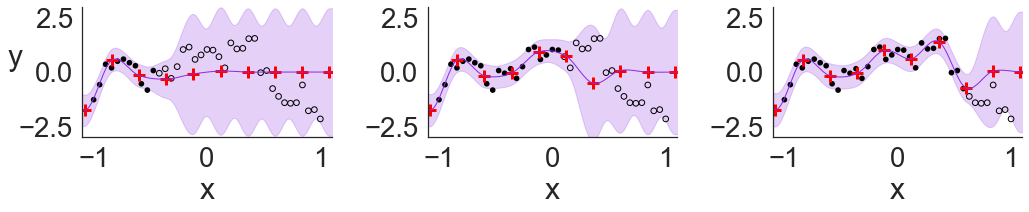

In [17]:
X, Y = get_data(num_rows=4 * chunk_size - 1, shuffle=False)
init_x, init_y, X, Y = preprocess_data(X, Y, num_init=chunk_size)

stem = Identity(input_dim=1)
covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=3)

wiski_model = models.OnlineSKIRegression(stem, init_x, init_y, lr=1e-1, grid_size=12, grid_bound=1, covar_module=covar_module)
wiski_model = try_cuda(wiski_model)
wiski_model.fit(init_x, init_y, 200)  # pretrain model

fig = plt.figure(figsize=(15, 4))
subplot_count = 1
wiski_model.set_lr(1e-2)
for t, (x, y) in enumerate(zip(X, Y)):
    wiski_model.update(x, y)
    if t % chunk_size == 0:
        inducing_x = wiski_model.gp.covar_module.grid[0][1:-1]
        inducing_f, _ = wiski_model.predict(inducing_x)
        train_x = torch.cat([init_x, X[:t+1]])
        train_y = torch.cat([init_y, Y[:t+1]])
        ax = fig.add_subplot(1, 3, subplot_count)
        if subplot_count == 1:
            ax.set_ylabel('y', rotation=0)
        subplot_count += 1

        ax = draw_plot(wiski_model, train_x, train_y, X[t+1:], Y[t+1:], inducing_x, inducing_f, ax,
                       model_colors['wiski_gp_regression'])
        
# fig.suptitle("WISKI, non-IID observations")
plt.subplots_adjust(top=0.80)
plt.savefig('./wiski_stock_price_non_iid.pdf')